In [1]:
# Needed to switch directory in Google drive so as to import MARL env.
from google.colab import drive 
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
!pwd
!pip install -r requirements.txt
!pip show tensorflow
!pip show ray

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
Obtaining gym_continuousDoubleAuction from git+https://github.com/ChuaCheowHuan/gym-continuousDoubleAuction.git@c897137cbcc93ca71cbd51c27e683c3298f6562d#egg=gym_continuousDoubleAuction (from -r requirements.txt (line 24))
  Skipping because already up-to-date.
  Using cached https://files.pythonhosted.org/packages/40/23/53ffe290341cd0855d595b0a2e7485932f473798af173bbe3a584b99bb06/tensorboard-2.1.0-py3-none-any.whl
ERROR: tensorflow-federated 0.12.0 has requirement cachetools~=3.1.1, but you'll have cachetools 4.0.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement grpcio~=1.24.3, but you'll have grpcio 1.27.2 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addon

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.tf.fcnet_v2 import FullyConnectedNetwork
from ray.rllib.models import Model, ModelCatalog
from ray.rllib.policy.policy import Policy
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.ppo.ppo_tf_policy import PPOTFPolicy
from ray.tune.logger import pretty_print

import sys
if "../" not in sys.path:
    sys.path.append("../")

from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv

tf = try_import_tf()

In [0]:
class CustomModel_1(Model):
    """
    Sample custom model with LSTM. 
    """

    def _lstm(self, Inputs, cell_size):
        s = tf.expand_dims(Inputs, axis=1, name='time_major')  # [time_step, feature] => [time_step, batch, feature]
        lstm_cell = tf.nn.rnn_cell.LSTMCell(cell_size)
        self.init_state = lstm_cell.zero_state(batch_size=1, dtype=tf.float32)
        # time_major means [time_step, batch, feature] while batch major means [batch, time_step, feature]
        outputs, self.final_state = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=s, initial_state=self.init_state, time_major=True)
        lstm_out = tf.reshape(outputs, [-1, cell_size], name='flatten_rnn_outputs')  # joined state representation
        return lstm_out
    
    def _build_layers_v2(self, input_dict, num_outputs, options):
        hidden = 512
        cell_size = 256
        #S = input_dict["obs"]
        S = tf.layers.flatten(input_dict["obs"])
        with tf.variable_scope(tf.VariableScope(tf.AUTO_REUSE, "shared"),
                               reuse=tf.AUTO_REUSE,
                               auxiliary_name_scope=False):
            last_layer = tf.layers.dense(S, hidden, activation=tf.nn.relu, name="fc1")
        last_layer = tf.layers.dense(last_layer, hidden, activation=tf.nn.relu, name="fc2")
        last_layer = tf.layers.dense(last_layer, hidden, activation=tf.nn.relu, name="fc3")

        last_layer = self._lstm(last_layer, cell_size)

        output = tf.layers.dense(last_layer, num_outputs, activation=tf.nn.softmax, name="mu")

        return output, last_layer

In [0]:
def make_RandomPolicy(_seed):

    class RandomPolicy(Policy):
        """
        A hand-coded policy that returns random actions in the env (doesn't learn).
        """        
        
        def __init__(self, observation_space, action_space, config):
            self.observation_space = observation_space
            self.action_space = action_space
            self.action_space.seed(_seed)

        def compute_actions(self,
                            obs_batch,
                            state_batches,
                            prev_action_batch=None,
                            prev_reward_batch=None,
                            info_batch=None,
                            episodes=None,
                            **kwargs):
            """Compute actions on a batch of observations."""
            return [self.action_space.sample() for _ in obs_batch], [], {}

        def learn_on_batch(self, samples):
            """No learning."""
            #return {}
            pass

        def get_weights(self):
            pass

        def set_weights(self, weights):
            pass

    return RandomPolicy

In [5]:
ray.init(ignore_reinit_error=True, log_to_driver=False, webui_host='127.0.0.1', num_cpus=2)

2020-03-21 16:10:31,158	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-21 16:10:31,161	INFO resource_spec.py:212 -- Starting Ray with 6.74 GiB memory available for workers and up to 3.38 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-21 16:10:31,681	INFO services.py:1078 -- View the Ray dashboard at 127.0.0.1:8265


{'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2020-03-21_16-10-31_156764_802/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-21_16-10-31_156764_802/sockets/raylet',
 'redis_address': '172.28.0.2:36187',
 'session_dir': '/tmp/ray/session_2020-03-21_16-10-31_156764_802',
 'webui_url': '127.0.0.1:8265'}

In [0]:
global_hist_stats = None # global var for charts

In [0]:
num_agents = 4
num_policies = num_agents # Each agent is using a separate policy
num_iters = 3
simple = False #store_true
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 1000000
max_step = 700 # per episode 
episode = 5 

In [8]:
single_CDA_env = continuousDoubleAuctionEnv(num_of_traders, init_cash, tick_size, tape_display_length, max_step)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space
register_env("continuousDoubleAuction-v0", lambda _: continuousDoubleAuctionEnv(num_of_traders, init_cash, tick_size, tape_display_length, max_step))
ModelCatalog.register_custom_model("model_disc", CustomModel_1)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
# Each policy can have a different configuration (including custom model)
def gen_policy(i):
    config = {"model": {"custom_model": "model_disc"},
              "gamma": 0.99,}
    return (None, obs_space, act_space, config)

In [0]:
def policy_mapper(agent_id):
    for i in range(num_agents):
        if agent_id == i:
            return "policy_{}".format(i)

In [0]:
# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i) for i in range(num_policies)}

In [12]:
def set_agents_policies(policies):
    """
    Set 1st policy as PPO & override all other policies as RandomPolicy with
    different seed.
    """
    
    # set all agents to use random policy
    for i in range(num_agents):
        policies["policy_{}".format(i)] = (make_RandomPolicy(i), obs_space, act_space, {})
    
    # set agent 0 & 1 to use None (PPOTFPolicy)
    offset = 2 # num of trained agents
    for i in range(num_agents-offset):
        #policies["policy_{}".format(i)] = (PPOTFPolicy, obs_space, act_space, {})
        policies["policy_{}".format(i)] = (None, obs_space, act_space, {})

    print('policies:', policies)
    return 0

set_agents_policies(policies)

policy_ids = list(policies.keys())

policies: {'policy_0': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_1': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_2': (<class '__main__.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_3': (<class '__main__.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {})}


In [0]:
def _cp_weight(trainer, src, dest):
    """
    Copy weights of src policy to destination policy.
    """
    P0key_P1val = {}
    for (k,v), (k2,v2) in zip(trainer.get_policy(dest).get_weights().items(), 
                              trainer.get_policy(src).get_weights().items()):            
        P0key_P1val[k] = v2

    trainer.set_weights({dest:P0key_P1val, 
                         src:trainer.get_policy(src).get_weights()})

    for (k,v), (k2,v2) in zip(trainer.get_policy(dest).get_weights().items(), 
                              trainer.get_policy(src).get_weights().items()):            
        assert (v == v2).all()    
    return 0

In [0]:
def on_train_result(info):
    """
    RLlib callback after each training iteration.

    info["trainer"] is the trainer object.

    info["result"] contains a bunch of info such as episodic rewards 
    for each policy in info["result"][hist_stats] dictionary.
    """

    # you can mutate the result dict to add new fields to return
    info["result"]["callback_ok"] = True

    trainer = info["trainer"] 
    update_global_hist_stats(info)
    max_reward_ind = get_max_reward_ind(info)
    train_policies_name, max_reward_policy_name = get_max_reward_policy_name(policies, max_reward_ind)
    cp_weight(trainer, train_policies_name, max_reward_policy_name)

In [0]:
def update_global_hist_stats(info):   
    """
    global_hist_stats for plotting.
    """

    global global_hist_stats 
    global_hist_stats = info['result']['hist_stats']

In [0]:
def get_max_reward_ind(info):
    """
    Get index of the max reward of the trained policies in most recent episode.
    """

    recent_policies_rewards = []
    i = 0
    offset = 2 # 1st 2 items are non-related
    num_trained_agent = 2
    for k, v in info['result']['hist_stats'].items():
        if i >= offset and i < offset + num_trained_agent:
            recent_policies_rewards.append(v[0])
        i = i + 1 
    max_reward_ind = np.argmax(recent_policies_rewards)
    return max_reward_ind

In [0]:
def get_max_reward_policy_name(policies, max_reward_ind):
    """
    Get the policy name of the trained policy with the max reward in most recent episode.
    """

    train_policies_name = []
    i = 0
    num_trained_agent = 2
    for k,v in policies.items():
        if i < num_trained_agent:
            train_policies_name.append(k)
        i = i + 1
    max_reward_policy_name = train_policies_name[max_reward_ind]
    return train_policies_name, max_reward_policy_name

In [0]:
def cp_weight(trainer, train_policies_name, max_reward_policy_name):
    """
    Copy weights of winning policy to weights of other trained policies.
    Winning is defined as getting max reward in the current episode.
    """

    for name in train_policies_name:
        if name != max_reward_policy_name:
            _cp_weight(trainer, max_reward_policy_name, name)   

In [19]:
def my_pyAPI_train():    
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": ["policy_0", "policy_1"],
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    config["num_workers"] = 1
    config["num_envs_per_worker"] = 2  
    config["batch_mode"] = "complete_episodes"
    config["train_batch_size"] = 128
    config["sample_batch_size"] = 32
    config["log_level"] = "WARN"
    config["callbacks"] = {"on_train_result": on_train_result,}
    
    local_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/chkpt/"
    chkpt = 261
    restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)

    trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    trainer.restore(restore_path) # uncomment to restore chkpt

    iter = 100
    for i in range(iter):
        result = trainer.train()
        print(pretty_print(result))

        if i % 10 == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)

    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)


my_pyAPI_train()            

2020-03-21 16:10:33,076	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-21 16:10:33,197	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

2020-03-21 16:10:53,033	INFO trainable.py:178 -- _setup took 19.853 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-03-21 16:10:53,035	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-03-21 16:10:53,402	WARNING trainable.py:210 -- Getting current IP.
2020-03-21 16:10:53,403	INFO trainable.py:416 -- Restored on 172.28.0.2 from checkpoint: /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/chkpt/checkpoint_261/checkpoint-261
2020-03-21 16:10:53,410	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 261, '_timesteps_total': 182961, '_time_total': 5760.947959184647, '_episodes_total': 261}


Streaming output truncated to the last 5000 lines.
      vf_loss: 8651485.0
    policy_1:
      cur_kl_coeff: 1.708593726158142
      cur_lr: 4.999999873689376e-05
      entropy: 7.478285312652588
      entropy_coeff: 0.0
      kl: 0.008881568908691406
      policy_loss: -0.11642472445964813
      total_loss: 2439750.75
      vf_explained_var: 0.002213168190792203
      vf_loss: 2439751.25
  load_time_ms: 2.756
  num_steps_sampled: 207496
  num_steps_trained: 189440
  sample_time_ms: 18483.811
  update_time_ms: 10.854
iterations_since_restore: 35
node_ip: 172.28.0.2
num_healthy_workers: 1
off_policy_estimator: {}
perf:
  cpu_util_percent: 58.361818181818165
  ram_util_percent: 18.779999999999998
pid: 802
policy_reward_max:
  policy_0: 67747.0
  policy_1: 112798.0
  policy_2: 42051.0
  policy_3: 66631.0
policy_reward_mean:
  policy_0: 3650.057142857143
  policy_1: 12884.542857142857
  policy_2: -10326.485714285714
  policy_3: -6208.114285714286
policy_reward_min:
  policy_0: -34151.0
  

In [0]:
def get_policies_hist_rewards(global_hist_stats):
    """
    Get episodic rewards for each agent.
    """

    policies_hist_rewards = []
    i = 0
    offset = 2 # 1st 2 items are unrelated
    num_agent = 4
    for k, v in global_hist_stats.items():
        if i >= offset and i < offset + num_agent:
            policies_hist_rewards.append(v)
        i = i + 1 
    return policies_hist_rewards

In [0]:
policies_hist_rewards = get_policies_hist_rewards(global_hist_stats)

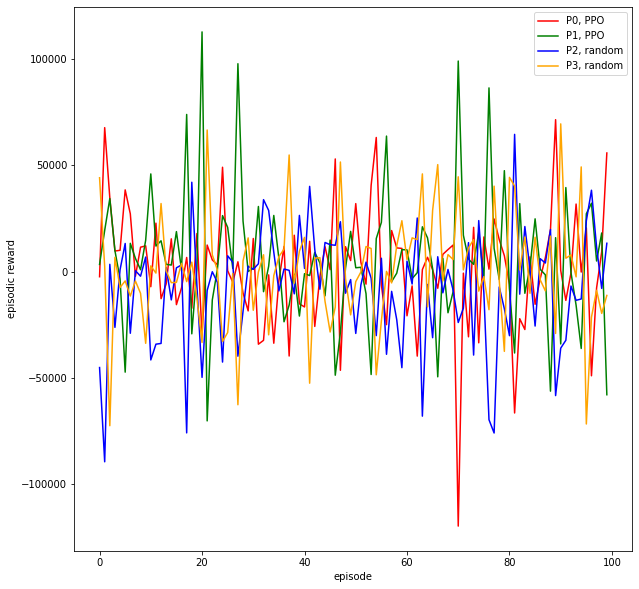

In [22]:
import matplotlib.pyplot as plt

x = range(len(policies_hist_rewards[0]))
p0 = policies_hist_rewards[0]
p1 = policies_hist_rewards[1]
p2 = policies_hist_rewards[2]
p3 = policies_hist_rewards[3]

plt.figure(figsize=(10,10))

plt.xlabel('episode')
plt.ylabel('episodic reward')

plt.plot(x, p0, 'r', label='P0, PPO') # plotting x, y
plt.plot(x, p1, 'g', label='P1, PPO') 
plt.plot(x, p2, 'b', label='P2, random') 
plt.plot(x, p3, 'orange', label='P3, random') 

plt.legend()
plt.show()

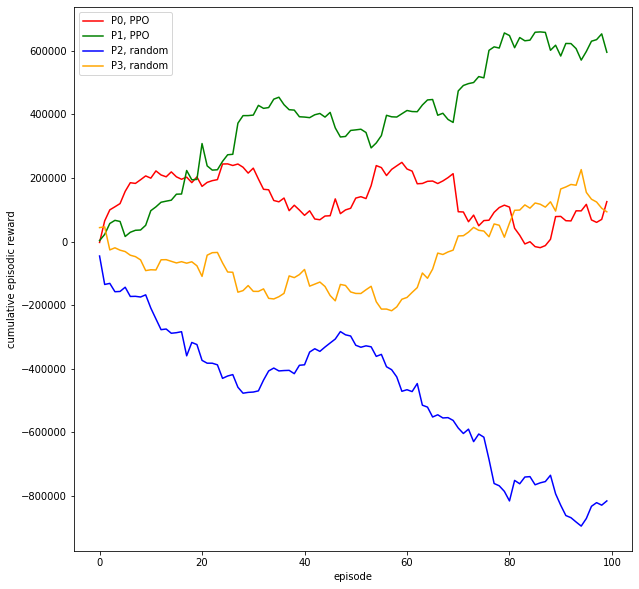

In [23]:
x = range(len(policies_hist_rewards[0]))
p0 = np.cumsum(policies_hist_rewards[0])
p1 = np.cumsum(policies_hist_rewards[1])
p2 = np.cumsum(policies_hist_rewards[2])
p3 = np.cumsum(policies_hist_rewards[3])

plt.figure(figsize=(10,10))

plt.xlabel('episode')
plt.ylabel('cumulative episodic reward')

plt.plot(x, p0, 'r', label='P0, PPO') # plotting x, y
plt.plot(x, p1, 'g', label='P1, PPO') 
plt.plot(x, p2, 'b', label='P2, random') 
plt.plot(x, p3, 'orange', label='P3, random') 

plt.legend()
plt.show()